## NFL ALL DAY Tournament: FINAL ROUND

#### Rusell Wilson low price prediction

In this round, you once again have full discretion over what you want to analyze. There's just one requirement: you must use some sort of predictive modeling to analyze any particular aspect of NFL All Day.



I.e. Could you build a model that predicts floor price after a certain designated period for a particular player? Once again, anything is fair game; we’d like to see what you come up with given the requirement of using ML.

Let’s start by importing some libraries which will be used for various purposes which will be explained later in this article. As well as the ShroomDK to be able to export NFL All Day data from Flispide database.

In [5]:
from shroomdk import ShroomDK
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as ticker
import numpy as np
sdk = ShroomDK("679043b4-298f-4b7f-9394-54d64db46007")

Now, we can write the code to extract the most important variable to develop our ML model.

In [53]:
sql = f"""SELECT
block_timestamp::date as date,
  play_type,
  moment_description,
  team,
  total_circulation,
count(distinct buyer) as n_buyers,
count(distinct seller) as n_sellers,
count(distinct x.nft_id) as n_nfts,
sum(price) as volume,
avg(price) as avg_price,
min(price) as min_price,
max(price) as max_price
from 
  flow.core.ez_nft_sales x
  left join flow.core.dim_allday_metadata y on x.nft_id = y.nft_id 
where player='Russell Wilson' and block_timestamp>='2021-01-01'
group by 1,2,3,4,5 order by 1 asc 
"""

In [54]:
results = sdk.query(sql)
df = pd.DataFrame(results.records)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1232 non-null   object 
 1   play_type           1232 non-null   object 
 2   moment_description  1232 non-null   object 
 3   team                1232 non-null   object 
 4   total_circulation   1232 non-null   int64  
 5   n_buyers            1232 non-null   int64  
 6   n_sellers           1232 non-null   int64  
 7   n_nfts              1232 non-null   int64  
 8   volume              1232 non-null   float64
 9   avg_price           1232 non-null   float64
 10  min_price           1232 non-null   float64
 11  max_price           1232 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 115.6+ KB


In [55]:
df.head()

,date,play_type,moment_description,team,total_circulation,n_buyers,n_sellers,n_nfts,volume,avg_price,min_price,max_price
0,2021-01-01,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,3,2,3,22.0,7.333333,5.0,11.0
1,2021-01-02,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,6,7,11,101.0,9.181818,1.0,29.0
2,2021-01-03,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,4,7,7,46.0,6.571429,1.0,14.0
3,2021-01-04,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,9,10,12,107.0,8.916667,1.0,23.0
4,2021-01-05,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,10,10,10,147.0,14.700000,1.0,44.0


We will be important other interesting and useful libraries to carry out the model.

Exploratory Data Analysis (EDA) is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

While performing the EDA of the Russel Wilson Price data we will analyze how prices of their NFTs have moved over the period of time and how the end of the quarters affects the prices of it.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


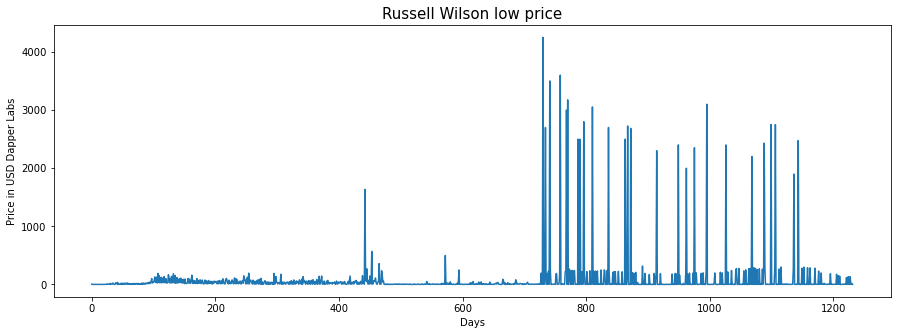

In [57]:
plt.figure(figsize=(15,5))
plt.plot(df['min_price'])
plt.title('Russell Wilson low price', fontsize=15)
plt.ylabel('Price in USD Dapper Labs')
plt.xlabel('Days')
plt.show()


As we can see in the first image above, we can see how the NFT price was stable during the first days, however, since some weeks ago, it started to oscilate reaching levels over 3k USD.

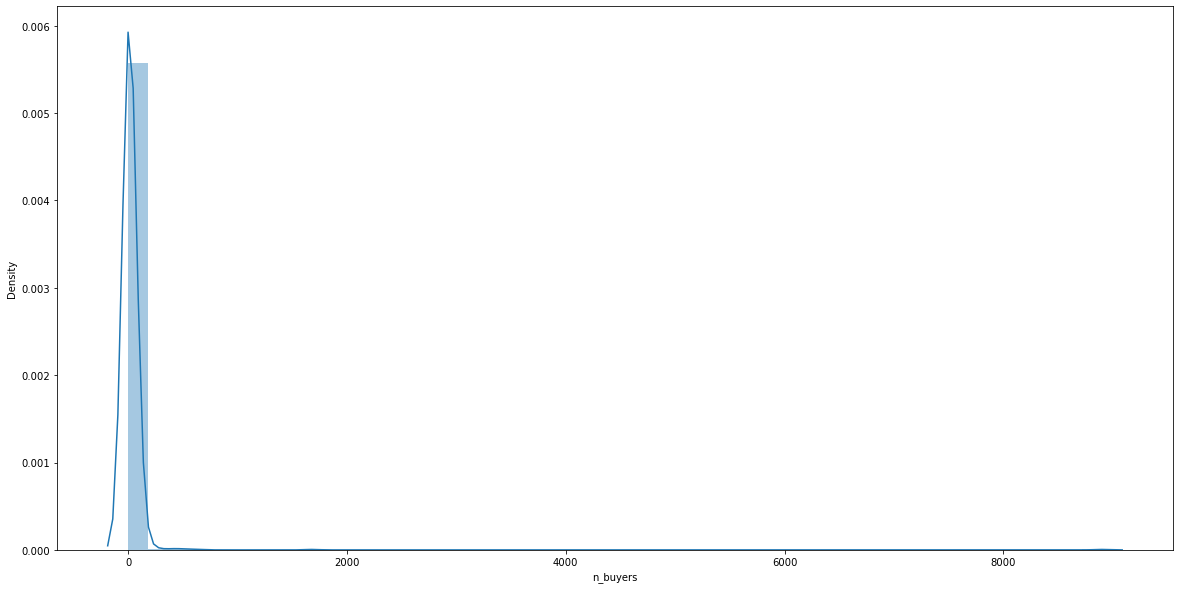

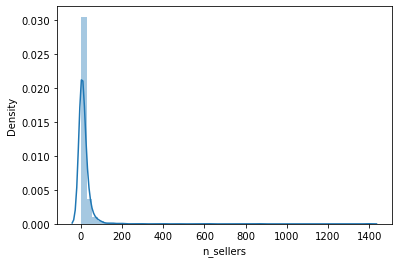

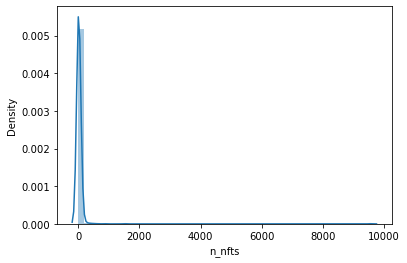

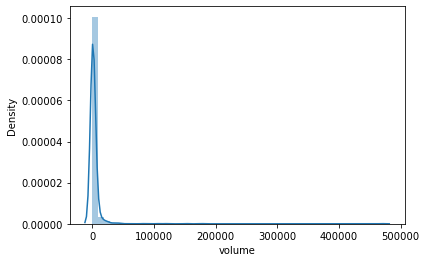

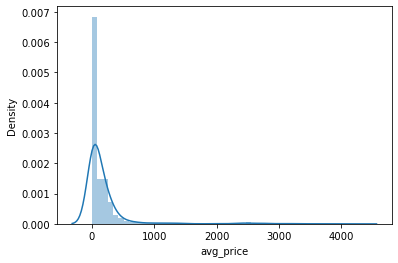

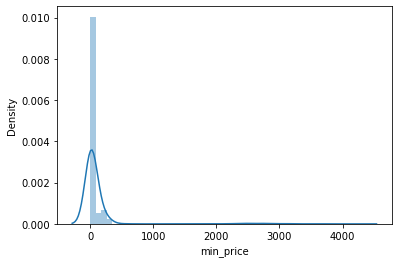

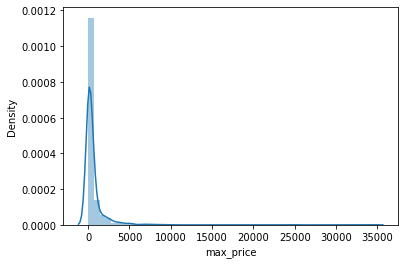

In [58]:
features = ['n_buyers', 'n_sellers', 'n_nfts', 'volume', 'avg_price','min_price','max_price']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    sb.distplot(df[col])
    plt.show()


In these other charts we can see the distribution of daily values among each calculated metrics. 

We have to highloght the poor distribution of number of buyers, and the number of different NFTs sold.The volume and number of sellers are a little bit more heterogeneous. The average, minimum and maximum prices vary a little bit more and have more normal distributions.

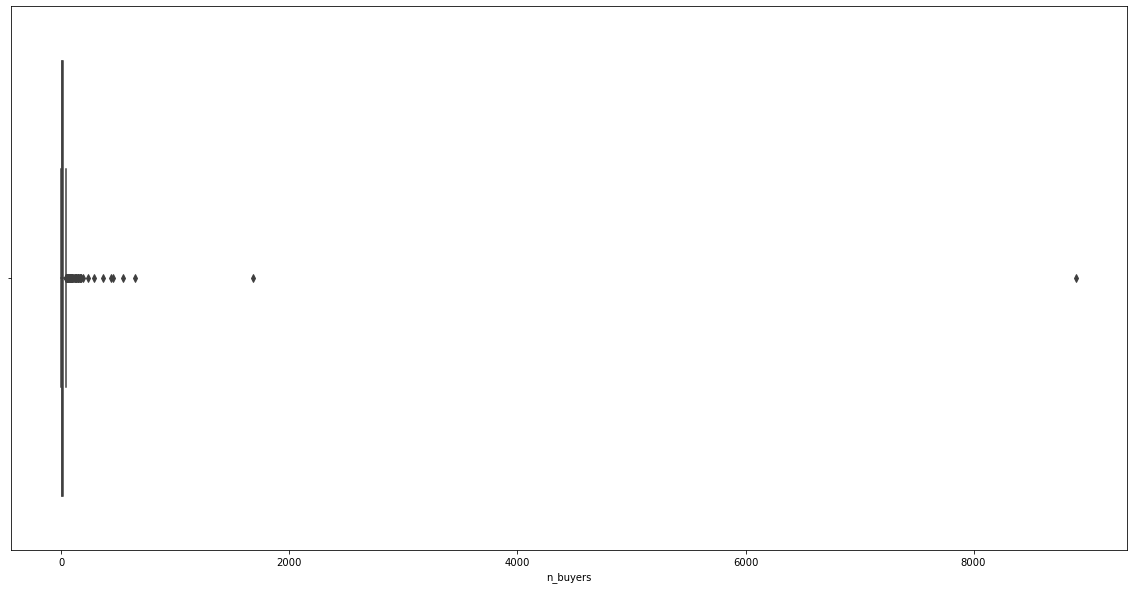

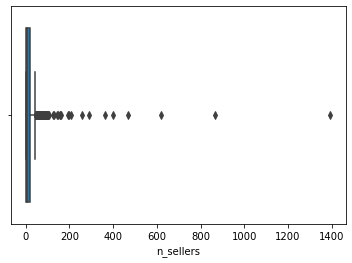

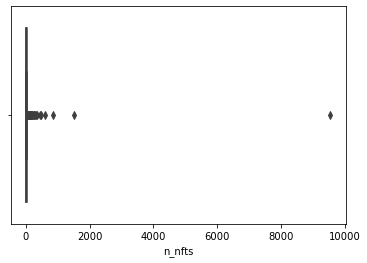

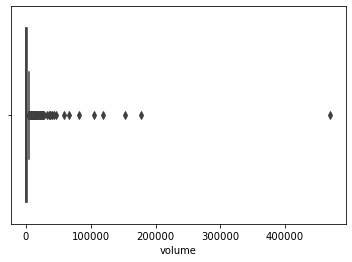

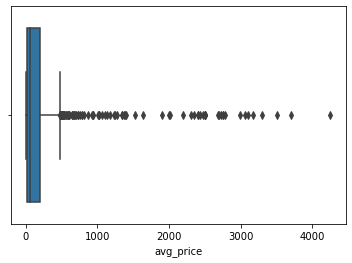

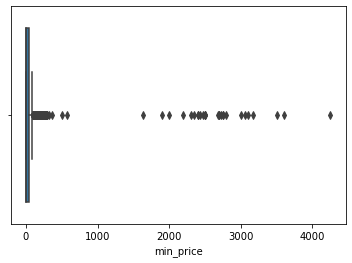

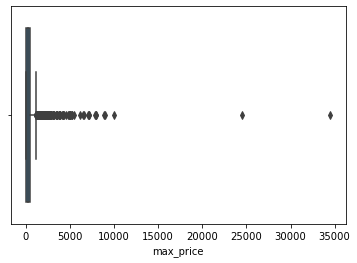

In [59]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    sb.boxplot(df[col])
    plt.show()


In all of the cases, it can be seen how there are some outliers. Thus, from the above boxplots, we can conclude that the major of the metrics data contains outliers.

In [65]:
splitted = df['date'].str.split('-', expand=True)

df['day'] = splitted[2].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[0].astype('int')

df.head()


,date,play_type,moment_description,team,total_circulation,n_buyers,n_sellers,n_nfts,volume,avg_price,min_price,max_price,day,month,year,is_quarter_end
0,2021-01-01,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,3,2,3,22.0,7.333333,5.0,11.0,1,1,2021,0
1,2021-01-02,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,6,7,11,101.0,9.181818,1.0,29.0,2,1,2021,0
2,2021-01-03,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,4,7,7,46.0,6.571429,1.0,14.0,3,1,2021,0
3,2021-01-04,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,9,10,12,107.0,8.916667,1.0,23.0,4,1,2021,0
4,2021-01-05,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,10,10,10,147.0,14.700000,1.0,44.0,5,1,2021,0


In [66]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()


,date,play_type,moment_description,team,total_circulation,n_buyers,n_sellers,n_nfts,volume,avg_price,min_price,max_price,day,month,year,is_quarter_end
0,2021-01-01,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,3,2,3,22.0,7.333333,5.0,11.0,1,1,2021,0
1,2021-01-02,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,6,7,11,101.0,9.181818,1.0,29.0,2,1,2021,0
2,2021-01-03,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,4,7,7,46.0,6.571429,1.0,14.0,3,1,2021,0
3,2021-01-04,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,9,10,12,107.0,8.916667,1.0,23.0,4,1,2021,0
4,2021-01-05,Pass,When Russell Wilson throws it up in a tight wi...,Seattle Seahawks,10000,10,10,10,147.0,14.700000,1.0,44.0,5,1,2021,0


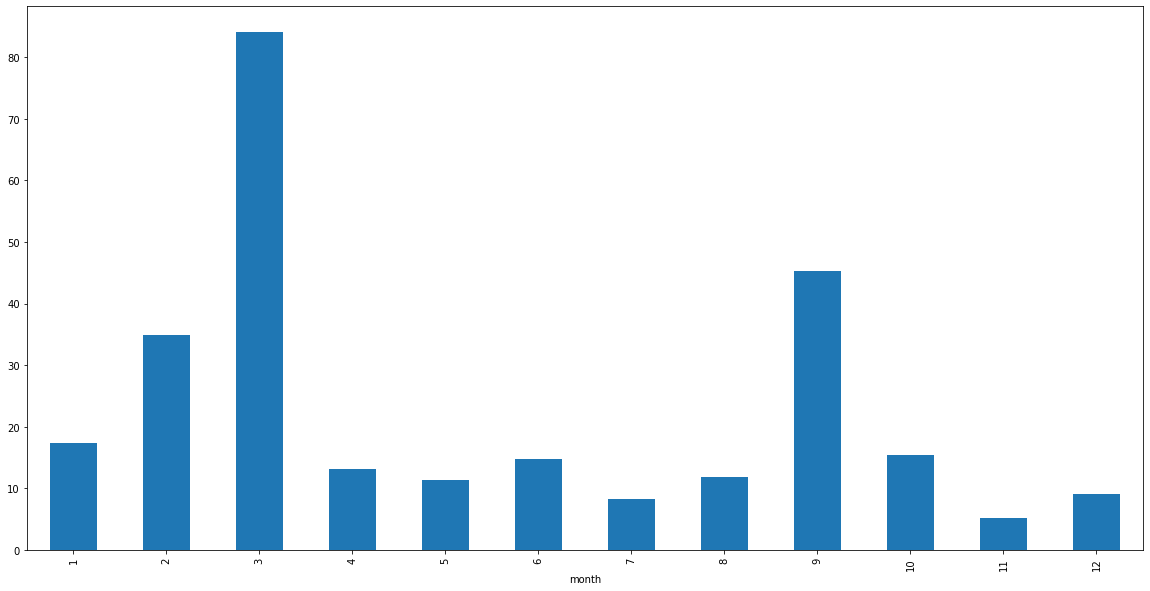

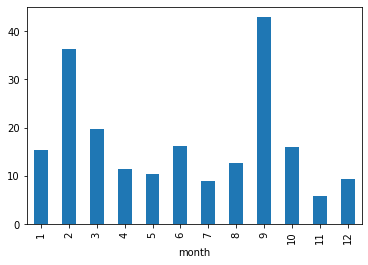

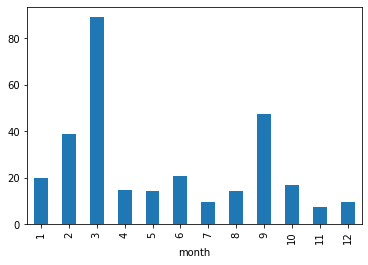

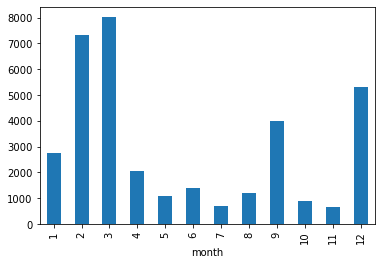

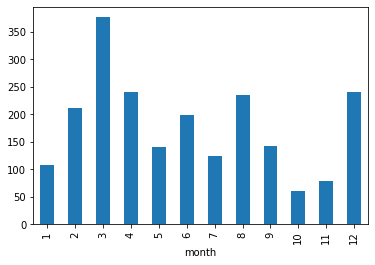

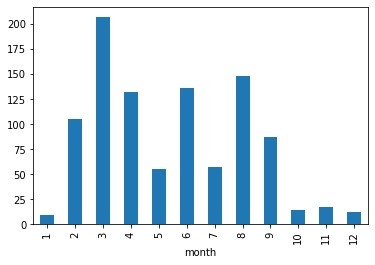

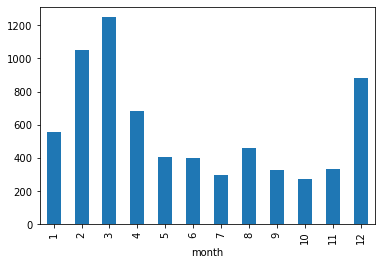

In [67]:
data_grouped = df.groupby('month').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['n_buyers', 'n_sellers', 'n_nfts', 'volume', 'avg_price','min_price','max_price']):
    data_grouped[col].plot.bar()
    plt.show()


Looking at this results, we can se that in the major of the cases, the highest values were obtained during 3rd and 9th month: March and September months, were more users were active, more volume was sold and the prices oscilated the most.

In [68]:
df.groupby('is_quarter_end').mean()


,total_circulation,n_buyers,n_sellers,n_nfts,volume,avg_price,min_price,max_price,day,month,year
is_quarter_end,,,,,,,,,,,
0,5696.929678,15.798570,15.680572,18.147795,2324.250426,160.914741,75.117417,540.182467,15.605483,5.450536,2021.494636
1,5707.455471,46.618321,23.781170,50.511450,4867.269364,251.034014,133.680728,732.718830,15.821883,6.435115,2021.488550


In [96]:
df['avg_price-min_price'] = df['avg_price'] - df['min_price']
df['min_price-max_price'] = df['min_price'] - df['max_price']
df['target'] = np.where(df['min_price'].shift(-1) < df['min_price'], 1, 0)


Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

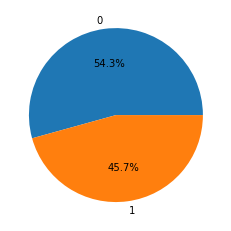

In [97]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()


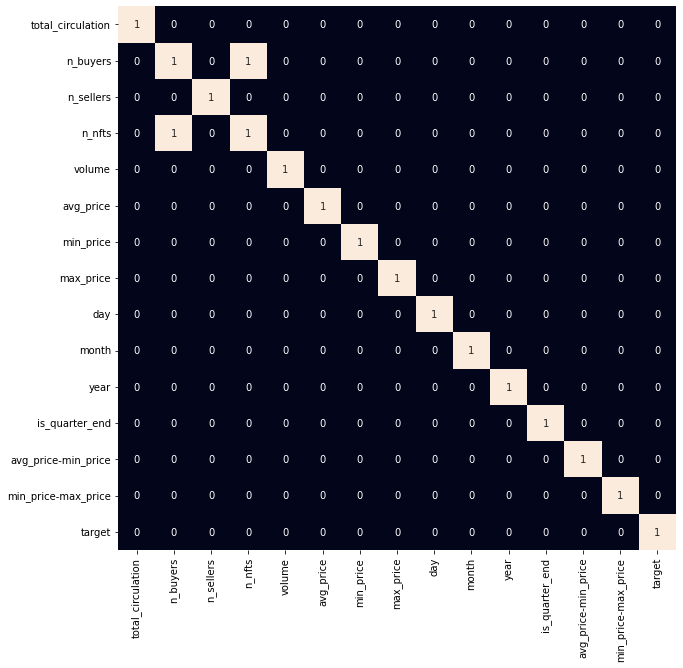

In [73]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()


When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

From the above heatmap, we can say that there is a high correlation between number of NFTs sold and number of buyers that is pretty obvious and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.



In [74]:
features = df[['avg_price-min_price', 'min_price-max_price', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)


(1108, 3) (124, 3)


After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [102]:
models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()
         ]

for i in range(3):
    models[i].fit(X_train, Y_train)

print(f'{models[i]} : ')
print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
print()


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 
Training Accuracy :  0.9447094429806948
Validation Accuracy :  0.6055381400208987



Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high. But in the case of the Logistic Regression, this is not the case.

Now let’s plot a confusion matrix for the validation data.

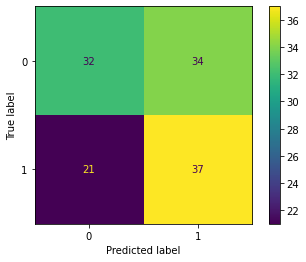

In [78]:
metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()


We can observe that the accuracy achieved by our ML model is better than simply guessing with a probability of 50%. This is good because it seems our model are working well. However, it should be improved by adding other features or having more data in order to obtain better outcomes and increase this probability.

#### Cooper Kupp low price analysis

In this second case, we will be trying to assess if the Cooper Kupp low price are gonna be lower or no on the next consecutive date. 

To do so, we will take into account the following metrics: play_type, moment_description, team, total_circulation, n_buyers, n_sellers, n_nfts, volume, avg_price, min_price, max_price, last_min_price.

As an outcome, we will have if the lowest price is a lower_low or not. Then, if the current lower price is a lower low, we will consider 1 as output, otherwise, 0.

In [108]:
sql = f"""SELECT
block_timestamp::date as date,
  play_type,
  moment_description,
  team,
  total_circulation,
count(distinct buyer) as n_buyers,
count(distinct seller) as n_sellers,
count(distinct x.nft_id) as n_nfts,
sum(price) as volume,
avg(price) as avg_price,
min(price) as min_price,
max(price) as max_price,
LAG(min_price,1) IGNORE NULLS OVER (ORDER BY date) as last_min_price,
case when min_price<last_min_price then 1 else 0 end as lower_low
from 
  flow.core.ez_nft_sales x
  left join flow.core.dim_allday_metadata y on x.nft_id = y.nft_id 
where player='Cooper Kupp'
group by 1,2,3,4,5 order by 1 asc 
"""

In [109]:
results = sdk.query(sql)
df = pd.DataFrame(results.records)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2515 non-null   object 
 1   play_type           2515 non-null   object 
 2   moment_description  2515 non-null   object 
 3   team                2515 non-null   object 
 4   total_circulation   2515 non-null   int64  
 5   n_buyers            2515 non-null   int64  
 6   n_sellers           2515 non-null   int64  
 7   n_nfts              2515 non-null   int64  
 8   volume              2515 non-null   float64
 9   avg_price           2515 non-null   float64
 10  min_price           2515 non-null   float64
 11  max_price           2515 non-null   float64
 12  last_min_price      2514 non-null   float64
 13  lower_low           2515 non-null   int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 275.2+ KB


In [110]:
df.head()

,date,play_type,moment_description,team,total_circulation,n_buyers,n_sellers,n_nfts,volume,avg_price,min_price,max_price,last_min_price,lower_low
0,2020-10-15,Player Melt,Behind him. In front of him. Low. High. Wherev...,Los Angeles Rams,1199,1,1,1,7.0,7.0,7.0,7.0,NaN,0
1,2020-10-21,Player Melt,Behind him. In front of him. Low. High. Wherev...,Los Angeles Rams,1199,1,1,1,1.0,1.0,1.0,1.0,7.0,1
2,2020-10-22,Player Melt,Behind him. In front of him. Low. High. Wherev...,Los Angeles Rams,1199,2,2,3,27.0,9.0,9.0,9.0,1.0,0
3,2020-10-23,Player Melt,Behind him. In front of him. Low. High. Wherev...,Los Angeles Rams,1199,2,2,2,9.0,4.5,1.0,8.0,9.0,1
4,2020-10-24,Player Melt,Behind him. In front of him. Low. High. Wherev...,Los Angeles Rams,1199,2,2,2,14.0,7.0,6.0,8.0,1.0,0


Now, we are gonna construct our model by determining our main features as well as our X_train, X_test, y_train, y_test. To do so we are gonna use the sklearn library from Python.

In [135]:
# all features

from sklearn.preprocessing import StandardScaler
features = ["play_type", "moment_description", "total_circulation", "n_buyers", "n_sellers", "n_nfts", "volume", "avg_price", "min_price", "max_price"]

X = df.iloc[1:, 4:-1].values 

y = df.iloc[1:, 13].values

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  ## splitting the data to get the test 

For our model, we will use different sklearn metrics such as the mean squared error, the make scorer, etc. and we will compute the results using not only the matthews correlation coefficient but also the f1_score to track which fit better with our model.

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.metrics import mean_squared_error, make_scorer, classification_report, confusion_matrix, matthews_corrcoef, f1_score
from sklearn.svm import SVC
import math
#from sklearn.ensemble import AdaBoostClassifier
#from imblearn.metrics import geometric_mean_score

#defining a custom metric 
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #Matthews correlation coefficient
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon()) 



threshold70=0.5
custom_scorer=make_scorer(matthews_corrcoef)
custom_scorer_2=make_scorer(f1_score)
#custom_scorer_3=make_scorer(geometric_mean_score)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  ## splitting the data to get the test 

y_train=y_train
y_test=y_test
X_train=X_train
X_test=X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

'''
#modify input_dim depending on number of features used
# Initialising the ANN
from keras.models import Sequential
from keras.layers import Dense,Dropout, LSTM
ann_70 = Sequential()
# Adding the input layer and the first hidden layer
ann_70.add(Dense(25, init = 'uniform', activation = 'relu', input_dim = 10)) #change input_dim depending on features' n
#ann_70.add(Dropout(0.5))
# Adding the output layer
ann_70.add(Dense(1, init = 'glorot_uniform', activation = 'relu'))
# Compiling the ANN
ann_70.compile(optimizer = 'adam', loss = 'mean_squared_error'  , metrics = ['accuracy',matthews_correlation])#'binary_crossentropy'
#fit method
#class_weight={0:1.,1:10}
ann_70.fit(X_train, y_train, batch_size = 10, epochs = 100,class_weight='balanced',verbose=0)
train_pred=ann_70.predict(X_train)
train_pred = (train_pred > threshold70)
y_pred = ann_70.predict(X_test)
y_pred = (y_pred > threshold70)
'''



# Initialising the SVM
parameter_dict = {'gamma':[0.1,0.01,0.001], 'C':[1,10,100]}
classifier = SVC(kernel='rbf',class_weight='balanced', probability=True,random_state=0)
svm70=GridSearchCV(classifier,cv=5,param_grid=parameter_dict,scoring=custom_scorer)
svm70.fit(X_train,y_train)
train_pred=svm70.best_estimator_.predict(X_train)
y_pred=svm70.best_estimator_.predict(X_test)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


'''
#Multinomial Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB
y_train=x['outcome']
y_test=x_t['outcome']
X_train=x[features]
X_test=x_t[features]
X_train['gROC']=abs(X_train['gROC'])
X_test['gROC']=abs(X_test['gROC'])
parameter_dict = {'alpha':[0.1,0.5, 1, 2, 6], 'fit_prior':[True, False]}
gnb70 = MultinomialNB()
gnb70=GridSearchCV(gnb70, param_grid=parameter_dict, scoring=custom_scorer_3)
gnb70 = gnb70.fit(X_train,y_train)
train_pred = gnb70.predict(X_train)
y_pred = gnb70.predict(X_test)
'''

'''
#adaboost sweep the parameter N_estimators manualy
#Adaboost 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
parameter_dict = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [5, 10, 20, 30, 50]
             }
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
ada = AdaBoostClassifier(base_estimator = DTC)
ada70 = GridSearchCV(ada, param_grid=parameter_dict, scoring = 'roc_auc')
ada70 = ada70.fit(X_train,y_train)
train_pred = ada70.predict(X_train)
y_pred = ada70.predict(X_test)
'''

'''
#adaboost sweep the parameter N_estimators manualy
#Adaboost 
ada = AdaBoostClassifier(n_estimators=50)
ada70=ada.fit(X_train,y_train)
train_pred = ada70.predict(X_train)
y_pred = ada70.predict(X_test)
'''

'''
# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50,100,200,300],'learning_rate':[1.0,2.0,4.0]}

# TODO: Make an fbeta_score scoring object
scorer2 = make_scorer(f1_score)


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
ada = GridSearchCV(clf,parameters,scoring=custom_scorer_3)

# TODO: Fit the grid search object to the training data and find the optimal parameters
ada = ada.fit(X_train,y_train)
train_pred = ada.predict(X_train)
y_pred = ada.predict(X_test)
'''

'''
#Initializing LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
parameter_dict = {'n_components': [5, 10, 15, 20, 25, 30], 'tol': [.1, .01, .001, .0001, .00001]}
lda = LDA()
model = GridSearchCV(lda, param_grid=parameter_dict)
#model = LDA(n_components=11)
X_lda = model.fit(X_train, y_train)
train_pred=X_lda.predict(X_train)
y_pred=X_lda.predict(X_test)
'''



#Evaluating training performance

################################################################
tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
mcc_train_70=round(matthews_corrcoef(y_train, train_pred),2)
sp_train_70=round(tn/(tn+fp),2)
se_train_70=round(tp/(tp+fn),2)

print("Train Classification report of SVM:",classification_report(y_train,train_pred))
print('Train Confusion Matrix of SVM:',confusion_matrix(y_train, train_pred).ravel())
print('Train Sensitivity of SVM:',se_train_70)
print('Train Specificity of SVM:', sp_train_70)
print('Train MCC of SVM:', mcc_train_70)

# Part 3 - Making the predictions and evaluating the model

# Making the Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
mcc_test_70=round(matthews_corrcoef(y_test, y_pred),2)
sp_test_70=round(tn/(tn+fp),2)
se_test_70=round(tp/(tp+fn),2)

print("Test Classification report of SVM:",classification_report(y_test,y_pred))
print('Test Confusion Matrix of SVM:',confusion_matrix(y_test, y_pred).ravel())
print('Test Sensitivity of SVM:',se_test_70)
print('Test Specificity of SVM:', sp_test_70)
print('Test MCC of SVM:', mcc_test_70)


Train Classification report of SVM:               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1076
           1       0.92      0.87      0.89       935

    accuracy                           0.90      2011
   macro avg       0.90      0.90      0.90      2011
weighted avg       0.90      0.90      0.90      2011

Train Confusion Matrix of SVM: [1006   70  125  810]
Train Sensitivity of SVM: 0.87
Train Specificity of SVM: 0.93
Train MCC of SVM: 0.81
Test Classification report of SVM:               precision    recall  f1-score   support

           0       0.86      0.92      0.89       253
           1       0.92      0.85      0.88       250

    accuracy                           0.89       503
   macro avg       0.89      0.89      0.89       503
weighted avg       0.89      0.89      0.89       503

Test Confusion Matrix of SVM: [234  19  37 213]
Test Sensitivity of SVM: 0.85
Test Specificity of SVM: 0.92
Test MCC of SVM: 0.78


Our ML technique that adapts better the model is the Support Vector Machine (SVM) which is one that plays better for price forecast so makes sense.

As you can see, we have considered different parameters. The best result have been obtained with the first parameters: gamma=0.1 and C=1.

Our classifier for the SVM has used a RBF kernel with a balanced weight.

**The most important thing is that our model has a specificity of 0.93. So its the same to say that our model has the ability to say that Cooper Kupp won't have a lower low the next day. Besides, the sensitivity is not low at all, it has a value of 0.87. So, the capacity of our model to detect that some day Cooper Kupp will reach a lower low is higher as well. In fact, our Matthews Correlation Score (MCC) is almost 0.8!**

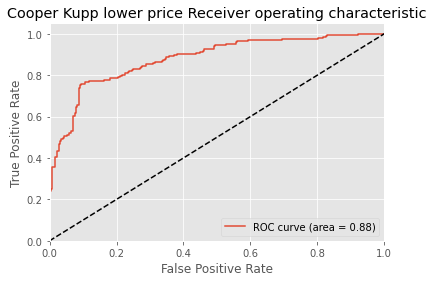

In [139]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
n_classes=len(y_train)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cooper Kupp lower price Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

To finish our analysis, I also plotted the Receiver operating characteristic of our model. As we can see, it has an area of 0.88, very close to 0.9, which is very positive for the validation of our model. This way, we can be sure that our target is very accurate and could even be used for other players.